# This notebook must be run with the Vizgen_2 conda environment within the Vizgen.sif singularity container

In [1]:
import scanpy as sc
import pandas as pd
import os
import string
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from tqdm import tqdm
import Mapping
import matplotlib.pyplot as plt
import multiprocessing as mp
from functools import partial

import skimage
import cv2
from skimage.morphology import disk, opening, closing
from scipy.ndimage import binary_fill_holes, label, distance_transform_edt
from skimage.segmentation import find_boundaries, watershed
from skimage.feature import peak_local_max
from skimage.measure import regionprops
from skimage.segmentation import watershed

import math
from numpy import matlib
from scipy.spatial.distance import euclidean

import scipy.spatial as spatial
from scipy.sparse import csr_matrix
from itertools import combinations

In [2]:
def find_filtered_transcripts(experiment_path):
    region_types = ['region_0', 'region_1']
    for region in region_types:
        file_path = f'{experiment_path}baysor/detected_transcripts.csv'
        if os.path.exists(file_path):
            return pd.read_csv(file_path,index_col=0)
    return None

def extract_sub_image_with_padding(image, bbox, padding=10):
    min_row, min_col, max_row, max_col = bbox
    min_row = max(min_row - padding, 0)
    min_col = max(min_col - padding, 0)
    max_row = min(max_row + padding, image.shape[0])
    max_col = min(max_col + padding, image.shape[1])
    return image[min_row:max_row, min_col:max_col], (min_row, min_col)

def load_images(batchID, x_ax, y_ax, raw_im, raw_dapi,transcripts):
    root = '/hpc/projects/group.quake/doug/Shapes_Spatial/'
    
    transform_file = f'{root}{batchID}/images/micron_to_mosaic_pixel_transform.csv'
    transform_df = pd.read_table(transform_file, sep=' ', header=None)
    transformation_matrix = transform_df.values
    
    x_ax = round(x_ax * transformation_matrix[0, 0] + transformation_matrix[0, 2])
    y_ax = round(y_ax * transformation_matrix[1, 1] + transformation_matrix[1, 2])
    
    #print(f'load {batchID}')
    #raw_im = Mapping.load_tiff_image(root + batchID + '/binary_image.tif')
    #dapi_im = Mapping.load_tiff_image(root + batchID + '/images/mosaic_DAPI_z3.tif')
    
    box_size = 500
    x_start = x_ax - box_size
    x_end = x_ax + box_size
    y_start = y_ax - box_size
    y_end = y_ax + box_size
    
    # Extract the sub-image, ensuring the indices are within bounds
    sub_image = np.zeros((2 * box_size, 2 * box_size), dtype=raw_im.dtype)
    sub_dapi = np.zeros((2 * box_size, 2 * box_size), dtype=raw_dapi.dtype)
    
    raw_x_start = max(x_start, 0)
    raw_x_end = min(x_end, raw_im.shape[1])
    raw_y_start = max(y_start, 0)
    raw_y_end = min(y_end, raw_im.shape[0])
    
    sub_x_start = max(0, -x_start)
    sub_x_end = sub_x_start + (raw_x_end - raw_x_start)
    sub_y_start = max(0, -y_start)
    sub_y_end = sub_y_start + (raw_y_end - raw_y_start)
    
    sub_image[sub_y_start:sub_y_end, sub_x_start:sub_x_end] = raw_im[raw_y_start:raw_y_end, raw_x_start:raw_x_end]
    sub_dapi[sub_y_start:sub_y_end, sub_x_start:sub_x_end] = raw_dapi[raw_y_start:raw_y_end, raw_x_start:raw_x_end]
    
    transcripts_sub = transcripts.loc[
        (transcripts.mosaic_x < raw_x_end) & (transcripts.mosaic_x > raw_x_start) &
        (transcripts.mosaic_y > raw_y_start) & (transcripts.mosaic_y < raw_y_end)
    ].copy()  # Explicitly create a copy

    # Now assign the new values without triggering the warning
    transcripts_sub['translate_x'] = transcripts_sub.mosaic_x - raw_x_start
    transcripts_sub['translate_y'] = transcripts_sub.mosaic_y - raw_y_start
    return sub_image, sub_dapi, transcripts_sub, (raw_y_start,raw_y_end, raw_x_start, raw_x_end)

def segment_image(im,window_size,foreground=True, dapi=False):
    if im.dtype == 'uint16':
        im = ((im - im.min()) / (im.max() - im.min()) * 255).astype(np.uint8)
    subtract = cv2.fastNlMeansDenoising(im)
    if foreground:
        pre = cv2.adaptiveThreshold((255 - subtract), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, window_size, 2)
    else:
        pre = cv2.adaptiveThreshold((subtract), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                cv2.THRESH_BINARY, window_size, 2)
    opened = opening(255 - pre, disk(3))
    pre = closing(opened, disk(3))
    filled_image = binary_fill_holes(pre).astype(np.uint8)
        
    return filled_image

def roi_picker(im, point=(500, 500), dapi=False):
    labeled_array, num_features = label(im)
    
    if dapi:
        # Apply distance transform
        distance = distance_transform_edt(labeled_array > 0)
        
        # Generate markers using connected components after thresholding
        coords = peak_local_max(distance, footprint=np.ones((9, 9)), labels=(labeled_array > 0))
        mask = np.zeros(distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = label(mask)
        # Apply watershed
        watershed_labels = watershed(-distance, markers, mask=(labeled_array > 0))
        
        # Update the labeled array with the watershed labels
        labeled_array = watershed_labels

        # Initialize variables to track the closest region
        closest_region_label = None
        min_distance = float('inf')
        regions = regionprops(labeled_array)

        # Find the closest region to the specified point
        for region in regions:
            if region.area > 500:
                # Calculate the distance from the point to the region's centroid
                region_centroid = np.array(region.centroid)
                distance = np.linalg.norm(region_centroid - np.array(point))

                # Update if this region is closer than previous ones
                if distance < min_distance:
                    min_distance = distance
                    closest_region_label = region.label

        if closest_region_label is not None:
            isolated_component = labeled_array == closest_region_label
            label_image = np.zeros_like(labeled_array)
            label_image[isolated_component] = 1
            return label_image
        else:
            return labeled_array
    else:
        # The original functionality to find the largest region near the point
        largest_component_label = None
        max_area = 0
        regions = regionprops(labeled_array)
        for region in regions:
            if region.area > 500:
                boundary_coords = np.column_stack(np.where(labeled_array == region.label))
                distances = np.linalg.norm(boundary_coords - np.array(point), axis=1)
                min_dist = np.min(distances)

                if min_dist < 50:
                    if region.area > max_area:
                        max_area = region.area
                        largest_component_label = region.label

        if largest_component_label is not None:
            isolated_component = labeled_array == largest_component_label
            label_image = np.zeros_like(labeled_array)
            label_image[isolated_component] = 1
            return label_image
        else:
            return labeled_array
        
def count_gene_overlaps(transcripts, dapi, micro, filled_dapi):
    """
    Counts the occurrences of barcodes (rows) for each gene that overlap with dapi_1, 
    with the binary difference of micro_1 - dapi_1, and with the binary difference of micro_1 - filled_dapi.
    
    Parameters:
        transcripts (pd.DataFrame): A DataFrame containing 'genes', 'translate_x', and 'translate_y' columns.
        dapi_1 (np.array): Binary image representing the region of interest (e.g., DAPI stained area).
        micro_1 (np.array): Binary image representing a larger or different region of interest.
        filled_dapi (np.array): Binary image representing another region of interest.
        
    Returns:
        result (pd.DataFrame): A subset of the input DataFrame 'transcripts' containing only the barcodes that overlap with
                               the binary difference between micro_1 and dapi_1 or the binary difference between 
                               micro_1 and filled_dapi, along with overlap counts per gene.
        dapi_only (pd.DataFrame): A subset of the input DataFrame 'transcripts' containing only the barcodes that overlap exclusively with dapi_1.
    """
    
    transcripts = transcripts.copy()
    # Calculate the differences
    binary_diff_dapi = np.logical_and(micro.astype(bool), np.logical_not(dapi.astype(bool)))
    binary_diff_filled_dapi = np.logical_and(micro.astype(bool), np.logical_not(filled_dapi.astype(bool)))
    
    results = transcripts[
        (transcripts['translate_x'].astype(int) >= 0) & (transcripts['translate_x'].astype(int) < binary_diff_filled_dapi.shape[1]) &
        (transcripts['translate_y'].astype(int) >= 0) & (transcripts['translate_y'].astype(int) < binary_diff_filled_dapi.shape[0])
    ]

    results = results[
        binary_diff_filled_dapi[results['translate_y'].astype(int), results['translate_x'].astype(int)]
    ]
    
    dapi_only = transcripts[
        (transcripts['translate_x'].astype(int) >= 0) & (transcripts['translate_x'].astype(int) < dapi.shape[1]) &
        (transcripts['translate_y'].astype(int) >= 0) & (transcripts['translate_y'].astype(int) < dapi.shape[0])
    ]

    dapi_only = dapi_only[
        dapi.astype(bool)[dapi_only['translate_y'].astype(int), dapi_only['translate_x'].astype(int)]
    ]
    

    return results, dapi_only

def calculate_areas(dataframe, dapi_labeled_array, non_dapi_labeled_array):
    """
    Calculate the total area of the DAPI (nucleus) and non-DAPI (non-nucleus) regions.

    Parameters:
        dataframe (pd.DataFrame): A DataFrame with one row, which will be used to create the output DataFrame.
        dapi_labeled_array (np.array): A labeled array where each unique integer represents a different object in the nucleus (DAPI).
        non_dapi_labeled_array (np.array): A labeled array where each unique integer represents a different object in the non-nucleus (Non-DAPI).

    Returns:
        result_df (pd.DataFrame): A DataFrame with the same index as the input DataFrame, containing two columns:
                                  'DAPI Area' and 'Non-DAPI Area'.
    """
    
    # Calculate total area for DAPI (nucleus)
    dapi_total_area = sum(region.area for region in regionprops(dapi_labeled_array))
    
    # Calculate total area for Non-DAPI (non-nucleus)
    non_dapi_total_area = sum(region.area for region in regionprops(non_dapi_labeled_array))
    
    # Create a new DataFrame to store the results
    result_df = pd.DataFrame({
        'DAPI Area': [dapi_total_area],
        'Non-DAPI Area': [non_dapi_total_area]
    }, index=dataframe.index)
    
    return result_df

def generate_counts_matrix(dataframe, var_names):
    """
    Generate a counts matrix where columns are genes and rows contain the number of barcodes 
    for that gene present in the dataframe.

    Parameters:
        dataframe (pd.DataFrame): The input DataFrame containing barcode information.
        var_names (list or pd.Index): List of gene names (matching adata.var_names).

    Returns:
        pd.DataFrame: A DataFrame with genes as columns and the number of barcodes for each gene.
    """
    # Filter the dataframe to only include genes in var_names
    filtered_df = dataframe[dataframe['gene'].isin(var_names)]
    
    # Count the number of barcodes for each gene
    counts = filtered_df['gene'].value_counts().reindex(var_names, fill_value=0)
    
    # Convert the counts to a DataFrame
    counts_df = counts.to_frame().T
    
    return counts_df

def rename_index(df, adata,transcript_df):
    counts_matrix_result = generate_counts_matrix(df,  transcript_df.gene.unique().tolist())
    counts_matrix_result.index = adata.obs.index
    return counts_matrix_result

def generate_transcript_spreadsheet(transcripts, dapi, micro, ad_test):
    # Calculate the union of dapi_1 and micro_1
    union_mask = np.logical_or(dapi.astype(bool), micro.astype(bool)) 

  # Filter transcripts to include only those within the union of dapi_1 and micro_1
    filtered_transcripts = transcripts[
        (transcripts['translate_x'].astype(int) >= 0) & (transcripts['translate_x'].astype(int) < union_mask.shape[1]) &
        (transcripts['translate_y'].astype(int) >= 0) & (transcripts['translate_y'].astype(int) < union_mask.shape[0])
    ]

    filtered_transcripts = filtered_transcripts[
        union_mask[filtered_transcripts['translate_y'].astype(int), filtered_transcripts['translate_x'].astype(int)]
    ]

    # Create a new DataFrame for the spreadsheet
    spreadsheet_df = pd.DataFrame({
        'x': filtered_transcripts['translate_x'].astype(int),
        'y': filtered_transcripts['translate_y'].astype(int),
        'gene': filtered_transcripts['gene'],
        'cell': ad_test.obs.Name.iloc[0]
    })
    return spreadsheet_df

def calculate_pairwise_distances(data):
    """
    Calculate pairwise Euclidean distances for a DataFrame containing 'x' and 'y' coordinates.

    Parameters:
    - data (pd.DataFrame): A DataFrame with columns 'x' and 'y' representing coordinates.

    Returns:
    - np.ndarray: An array of pairwise distances.
    """
    hold_data = data.copy()
    
    # Extract x and y coordinates as a NumPy array
    coords = hold_data[['x', 'y']].to_numpy()

    # Compute pairwise distances using combinations
    distances = [
        np.sqrt((x1 - x2)**2 + (y1 - y2)**2)
        for (x1, y1), (x2, y2) in combinations(coords, 2)
    ]
    
    return np.array(distances)

In [3]:
ad_parent = sc.read_h5ad('../03_morph_embedding/Shape_500.h5ad')
ad_parent = ad_parent[ad_parent.obs.updated_celltype == 'Microglia']
place_in_order = place_in_order = {
    0: '4',
    1: '1',
    2: '2',
    3: '0',
    4: '3',
}

ad_parent.obs['ordered_morph'] = ad_parent.obs.morph_leiden.map(place_in_order)
ad_parent = ad_parent[ad_parent.obs['ordered_morph'] == '4']

experiment_base_paths = ['/hpc/projects/group.quake/doug/Shapes_Spatial/3-mo-male-1/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/3-mo-male-2/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/3-mo-male-3-rev2/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/3-mo-female-1-rev2/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/3-mo-female-2/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/3-mo-female-3/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/24-mo-male-1/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/24-mo-male-2/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/24-mo-male-4-rev2/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/24-mo-female-1/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/24-mo-female-3/',
                         '/hpc/projects/group.quake/doug/Shapes_Spatial/24-mo-female-5/',
                        ]

for experiment in experiment_base_paths:
    batch = experiment.split('/')[-2]
    # We also want to load in the geometry file
    ad_viz = ad_parent[ad_parent.obs.batchID == batch]
    transform_file = f'{experiment}/images/micron_to_mosaic_pixel_transform.csv'
    transform_matrix = pd.read_table(transform_file, sep=' ', header=None).iloc[:2]
    transcripts = find_filtered_transcripts(experiment)
    transcripts['mosaic_x'], transcripts['mosaic_y'] = transcripts.global_x * transform_matrix.iloc[0,0] + transform_matrix.iloc[0,2], transcripts.global_y * transform_matrix.iloc[1,1] + transform_matrix.iloc[1,2]
    blank_names = transcripts[transcripts.gene.str.contains('Blank')].gene.unique().tolist()

    root = '/hpc/projects/group.quake/doug/Shapes_Spatial/'
    raw_im = Mapping.load_tiff_image(root + batch + '/binary_image.tif')
    raw_dapi = Mapping.load_tiff_image(root + batch + '/images/mosaic_DAPI_z3.tif')
    
    gene_col = 'gene'
    genes = np.unique(transcripts.gene.unique().tolist())
    normalized_distances_dict = {}
    all_distances_soma = []
    for i in tqdm(range(len(ad_viz)), desc=f"Processing {batch}"):
        ad_test = ad_viz[i,:]
        small_raw, small_dapi, small_transcripts, image_loc = load_images(batch, ad_test.obs.x.iloc[0], ad_test.obs.y.iloc[0],raw_im, raw_dapi,transcripts)
    
        filled_raw = segment_image(small_raw, 205, foreground=True)
        filled_dapi = segment_image(small_dapi, 255, foreground=True, dapi=True)
    
        micro_1 = roi_picker(filled_raw)
        dapi_1 = roi_picker(filled_dapi,dapi=True)
        total_1 = np.logical_or(dapi_1.astype(bool), micro_1.astype(bool))
        non_dapi_1 = np.logical_and(micro_1.astype(bool), np.logical_not(filled_dapi.astype(bool))).astype(np.uint8)
    
        counts_non_nuclei, counts_nuclei = count_gene_overlaps(small_transcripts,dapi_1,micro_1,filled_dapi)
    
        counts_matrix_result_full = rename_index(counts_non_nuclei,ad_test,transcripts)
        counts_matrix_result_dapi = rename_index(counts_nuclei,ad_test,transcripts)
        #area_results = calculate_areas(ad_test.obs, dapi_1, label(np.logical_and(micro_1.astype(bool), np.logical_not(filled_dapi.astype(bool))).astype(np.uint8))[0])
        sub_full_trans = generate_transcript_spreadsheet(small_transcripts, dapi_1, micro_1, ad_test)
        counts_matrix_full = rename_index(sub_full_trans,ad_test,transcripts)
        
        counts_nuclei['x'] = counts_nuclei['translate_x'] / transform_matrix.iloc[0, 0]
        counts_nuclei['y'] = counts_nuclei['translate_y'] / transform_matrix.iloc[1, 1]
        
        counts_non_nuclei['x'] = counts_non_nuclei['translate_x'] / transform_matrix.iloc[0, 0]
        counts_non_nuclei['y'] = counts_non_nuclei['translate_y'] / transform_matrix.iloc[1, 1]
        
        distances_soma = calculate_pairwise_distances(counts_nuclei)
        all_distances_soma.append(distances_soma)

/tmp/ipykernel_1470385/2727366367.py:11: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  ad_parent.obs['ordered_morph'] = ad_parent.obs.morph_leiden.map(place_in_order)
Processing 24-mo-female-5: 100%|██████████| 78/78 [03:20<00:00,  2.57s/it]


In [4]:
np.percentile(np.concatenate(all_distances_soma),5)

1.0309949121235311

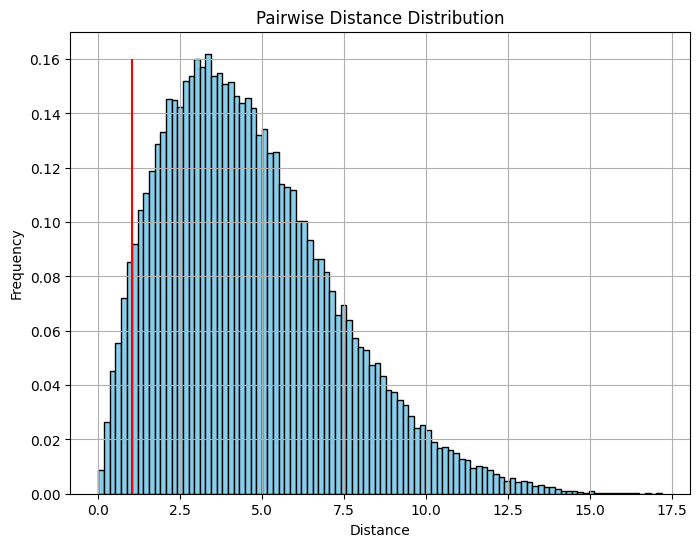

In [6]:
os.makedirs('Figures/Figure_coloc', exist_ok=True)
plt.figure(figsize=(8, 6))
plt.hist(np.concatenate(all_distances_soma), bins=100, color='skyblue', edgecolor='black',density=True)
plt.vlines(np.percentile(np.concatenate(all_distances_soma),5),0,0.16,color='r')
plt.title('Pairwise Distance Distribution')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('Figures/Figure_coloc/distances_histogram.pdf',format='pdf')
plt.show()